In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
# importing what we need
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltm
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [6]:
# creating two lists contain our files
with_mask_files = os.listdir('/content/data/with_mask')
without_mask_files = os.listdir('/content/data/without_mask')


In [7]:
# check the size
len(with_mask_files),len(without_mask_files)

(3725, 3828)

In [8]:
# create the labels
with_mask_labels = [1]*3725
without_mask_labels = [0]*3828

In [9]:
# here i add them to create a list of ones and zeros
labels = with_mask_labels + without_mask_labels

In [10]:
with_mask_files[0],without_mask_files[0]

('with_mask_2931.jpg', 'without_mask_349.jpg')

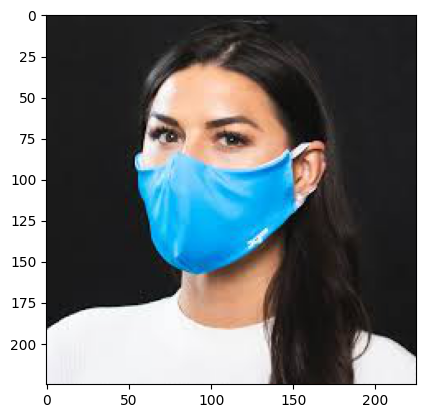

In [11]:
# displaying with mask image
img = pltm.imread('/content/data/with_mask/with_mask_822.jpg')
imgplot = plt.imshow(img)
plt.show()

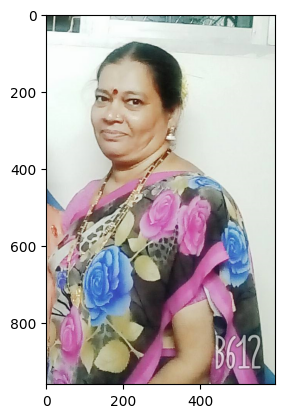

In [12]:
# displaying without mask image
img = pltm.imread('/content/data/without_mask/without_mask_3535.jpg')
imgplot = plt.imshow(img)
plt.show()

In [13]:
# convert images to tensors
import tensorflow as tf
with_mask_path = '/content/data/with_mask/'

data = []

for img_file in with_mask_files:

  image = Image.open(with_mask_path + img_file) # from PIL
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  image = tf.convert_to_tensor(image)
  data.append(image)



without_mask_path = '/content/data/without_mask/'


for img_file in without_mask_files:

  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  image = tf.convert_to_tensor(image)
  data.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
type(data),len(data),data[0]

(list,
 7553,
 <tf.Tensor: shape=(128, 128, 3), dtype=uint8, numpy=
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],


In [15]:
# converting image list and label list to tensor

X = tf.convert_to_tensor(data)
Y = tf.convert_to_tensor(labels)

In [16]:
X.shape,Y.shape

(TensorShape([7553, 128, 128, 3]), TensorShape([7553]))

### train test split

In [17]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)   # random_state is a parameter that gives the order
train_size = int(0.8*len(X))
tf.random.set_seed(40)
X = tf.random.shuffle(X,seed=40)
Y = tf.random.shuffle(Y,seed=40)
X_train,X_test = tf.split(X,[train_size,len(X)-train_size])
Y_train,Y_test = tf.split(Y,[train_size,len(X)-train_size])


In [18]:
X.shape, X_train.shape, X_test.shape

(TensorShape([7553, 128, 128, 3]),
 TensorShape([6042, 128, 128, 3]),
 TensorShape([1511, 128, 128, 3]))

In [19]:
# scaling the data
X_train_scaled = X_train/255
X_test_scaled = X_test/255

### Building a Convolutional Neural Networks (CNN)

In [20]:
from tensorflow import keras
num_of_classes = 2

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

In [21]:
# compile the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [22]:
# training the neural network
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=30)

Epoch 1/30
170/170 [==============================] - 18s 24ms/step - loss: 0.4225 - acc: 0.7984 - val_loss: 0.2460 - val_acc: 0.8959
Epoch 2/30
170/170 [==============================] - 3s 19ms/step - loss: 0.2388 - acc: 0.9130 - val_loss: 0.1666 - val_acc: 0.9438
Epoch 3/30
170/170 [==============================] - 3s 18ms/step - loss: 0.1974 - acc: 0.9327 - val_loss: 0.2763 - val_acc: 0.8893
Epoch 4/30
170/170 [==============================] - 3s 18ms/step - loss: 0.1710 - acc: 0.9415 - val_loss: 0.1641 - val_acc: 0.9372
Epoch 5/30
170/170 [==============================] - 3s 20ms/step - loss: 0.1396 - acc: 0.9531 - val_loss: 0.1401 - val_acc: 0.9488
Epoch 6/30
170/170 [==============================] - 3s 19ms/step - loss: 0.1228 - acc: 0.9581 - val_loss: 0.1299 - val_acc: 0.9636
Epoch 7/30
170/170 [==============================] - 3s 18ms/step - loss: 0.1130 - acc: 0.9603 - val_loss: 0.1295 - val_acc: 0.9603
Epoch 8/30
170/170 [==============================] - 3s 18ms/step -

In [23]:
# evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy) # you'll get 0.976....

48/48 [==============================] - 1s 13ms/step - loss: 0.1503 - acc: 0.9762
Test Accuracy = 0.9761747121810913


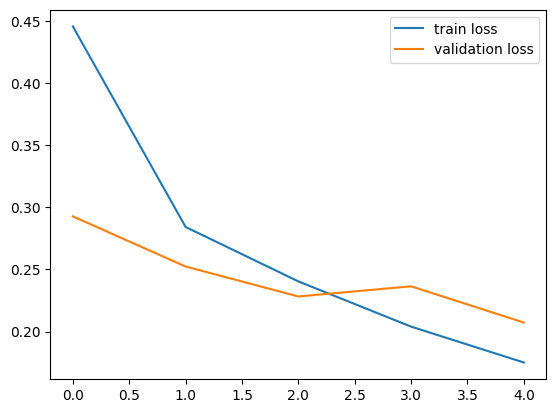

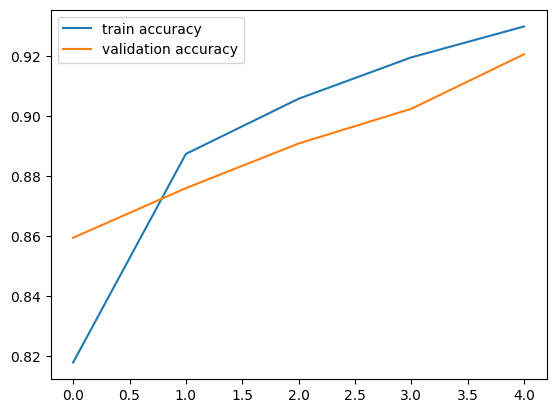

In [ ]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

Path of the image to be predicted: /content/Screenshot from 2023-07-03 01-00-00.png


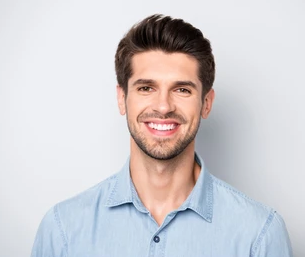

1/1 [==============================] - 0s 20ms/step
[[0.46229973 0.5557511 ]]
1
The person in the image is not wearing a mask


In [ ]:
# prediction
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 0:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')